# 1. Importer

## 1.1 Les modules nécessaire

In [11]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ExponentialLR, ReduceLROnPlateau, CosineAnnealingLR, LambdaLR

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from typing import List, Union, Optional

import time
from datetime import datetime, timedelta

import warnings
from typing import Dict, List, Tuple, Union
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

GPU Name: NVIDIA GeForce RTX 3060 Laptop GPU
GPU Memory: 6.44 GB


## 1.2 Des données

In [13]:
data = pd.read_csv('Physical experiments.csv',sep= ';')
num = data.select_dtypes(np.number)
cat= data.select_dtypes(exclude=np.number)
data.head()

,X Axis,Y Axis,Z Axis,speed,std speed,flashes,height,flash time,number of flashes,time,direction
0,0,0,0,"7,732100079","21,27411752","0,836535186","0,893909107","37,5",12.0,"19,40939338",V
1,0,1,0,"8,93297619","24,14391967","0,997566682","0,981108211","41,78899083",327.0,"19,99695986",U
2,0,2,0,"1,4209136","25,14055993","0,992084814","0,964873731","42,41145833",576.0,"20,02562567",U
3,0,3,0,"-7,024316029","23,48523655","0,989346321","0,951449147","44,36641221",655.0,"19,95115159",U
4,0,4,0,"-14,05511477","25,16917632","0,987477067","0,930151443","46,10802139",935.0,"19,96782501",U


# 2. Preprocessing

In [15]:
class DataPreprocessor:
    def __init__(self, 
                 numerical_features: List[str] = None,
                 categorical_features: List[str] = None,
                 scaling_method: str = 'standard',
                 categorical_encoding: str = 'onehot',
                 max_categories: int = 10):
        """
        Initialize the preprocessor with feature specifications
        
        Args:
            numerical_features: List of numerical column names
            categorical_features: List of categorical column names
            scaling_method: 'standard', 'minmax', or 'robust'
            categorical_encoding: 'onehot' or 'label'
            max_categories: Maximum number of categories for one-hot encoding
        """
        self.numerical_features = numerical_features
        self.categorical_features = categorical_features
        self.scaling_method = scaling_method
        self.categorical_encoding = categorical_encoding
        self.max_categories = max_categories
        
        # Initialize transformers
        self.numerical_transformer = None
        self.categorical_transformer = None
        self.ordinal_encoders = {}
        self.column_transformer = None
        self.feature_names_out_ = None
    def fill_num(self,num: pd.DataFrame):
        null_map = num.isnull().sum()
        cols_contain_null = null_map.index[null_map >0 ]
        for col in cols_contain_null:
            num[col] = num[col].fillna(num[col].median())
        return num

        
    def _create_numerical_transformer(self):
        """Create transformer for numerical features"""
        if self.scaling_method == 'standard':
            return StandardScaler()
        elif self.scaling_method == 'minmax':
            return MinMaxScaler()
        elif self.scaling_method == 'robust':
            return RobustScaler()
        else:
            raise ValueError(f"Unknown scaling method: {self.scaling_method}")
            
    def _create_categorical_transformer(self):
        """Create transformer for categorical features"""
        if self.categorical_encoding == 'onehot':
            return OneHotEncoder(sparse=False, handle_unknown='ignore', 
                               max_categories=self.max_categories)
        elif self.categorical_encoding == 'label':
            return LabelEncoder()
        else:
            raise ValueError(f"Unknown categorical encoding: {self.categorical_encoding}")
            
    def detect_feature_types(self, data: pd.DataFrame) -> None:
        """Automatically detect feature types if not specified"""
        if self.numerical_features is None and self.categorical_features is None:
            self.numerical_features = []
            self.categorical_features = []
            
            for column in data.columns:
                if data[column].dtype in ['int64', 'float64']:
                    self.numerical_features.append(column)
                else:
                    self.categorical_features.append(column)
                    
            print(f"Detected {len(self.numerical_features)} numerical features")
            print(f"Detected {len(self.categorical_features)} categorical features")
    
    def fit(self, data: pd.DataFrame) -> 'DataPreprocessor':
        """Fit the preprocessor to the data"""
        # Detect feature types if not specified
        self.detect_feature_types(data)
        
        # Create transformers
        transformers = []
        
        # Numerical features
        if self.numerical_features:
            self.numerical_transformer = Pipeline([
                ('imputer', SimpleImputer(strategy='mean')),
                ('scaler', self._create_numerical_transformer())
            ])
            transformers.append(('num', self.numerical_transformer, self.numerical_features))
        
        # Categorical features
        if self.categorical_features:
            self.categorical_transformer = Pipeline([
                ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                ('encoder', self._create_categorical_transformer())
            ])
            transformers.append(('cat', self.categorical_transformer, self.categorical_features))
        
        
        # Create and fit column transformer
        self.column_transformer = ColumnTransformer(
            transformers=transformers,
            remainder='drop'
        )
        
        self.column_transformer.fit(data)
        
        # Store feature names
        self.feature_names_out_ = (
            self.numerical_features +
            ([] if not self.categorical_features else 
             self.column_transformer.named_transformers_['cat']
             .named_steps['encoder'].get_feature_names(self.categorical_features).tolist()))
        
        return self
    
    def transform(self, data: pd.DataFrame) -> np.ndarray:
        """Transform the data"""
        if self.column_transformer is None:
            raise ValueError("Preprocessor must be fitted before transform")
        
        return self.column_transformer.transform(data)
    
    def fit_transform(self, data: pd.DataFrame) -> np.ndarray:
        """Fit and transform the data"""
        return self.fit(data).transform(data)
    
    def inverse_transform(self, transformed_data: np.ndarray) -> pd.DataFrame:
        """Inverse transform the data back to original space"""
        if self.column_transformer is None:
            raise ValueError("Preprocessor must be fitted before inverse_transform")
        
        # Split the transformed data into parts for each transformer
        current_idx = 0
        parts = {}
        
        # Numerical features
        if self.numerical_features:
            n_numerical = len(self.numerical_features)
            parts['num'] = transformed_data[:, current_idx:current_idx + n_numerical]
            current_idx += n_numerical
        
        # Categorical features
        if self.categorical_features and self.categorical_encoding == 'onehot':
            n_categorical = len(self.column_transformer.named_transformers_['cat']
                              .named_steps['encoder'].get_feature_names(self.categorical_features))
            parts['cat'] = transformed_data[:, current_idx:current_idx + n_categorical]
            current_idx += n_categorical
        
        
        # Inverse transform each part
        inverse_transformed = {}
        
        # Numerical features
        if self.numerical_features:
            inverse_numerical = self.numerical_transformer.inverse_transform(parts['num'])
            for i, feature in enumerate(self.numerical_features):
                inverse_transformed[feature] = inverse_numerical[:, i]
        
        # Categorical features
        if self.categorical_features:
            if self.categorical_encoding == 'onehot':
                inverse_categorical = self.categorical_transformer.named_steps['encoder'].inverse_transform(parts['cat'])
                for i, feature in enumerate(self.categorical_features):
                    inverse_transformed[feature] = inverse_categorical[:, i]
        
        
        return pd.DataFrame(inverse_transformed)

# Example usage
def preprocess_data_for_tvae(data: pd.DataFrame, 
                            scaling_method: str = 'standard',
                            categorical_encoding: str = 'onehot',
                            max_categories: int = 10):
    """
    Preprocess data specifically for TVAE model
    
    Args:
        data: Input DataFrame
        scaling_method: Scaling method for numerical features
        categorical_encoding: Encoding method for categorical features
        max_categories: Maximum number of categories for one-hot encoding
        
    Returns:
        Tuple of (preprocessed_data, preprocessor)
    """
    # Create preprocessor
    preprocessor = DataPreprocessor(
        scaling_method=scaling_method,
        categorical_encoding=categorical_encoding,
        max_categories=max_categories
    )
    
    # Fit and transform data
    preprocessed_data = preprocessor.fit_transform(data)
    
    return preprocessed_data, preprocessor


In [16]:
    
    # Create preprocessor
preprocessor = DataPreprocessor(
        categorical_features= cat.columns,
        numerical_features=num.columns,
        scaling_method='standard',
        categorical_encoding='onehot'
    )
    
    # Preprocess data
num = preprocessor.fill_num(num)
#preprocessed_data = preprocessor.fit_transform(data)
    
#print("\nOriginal data shape:", data.shape)
#print("Preprocessed data shape:", preprocessed_data.shape)
#print("\nFeature names:", preprocessor.feature_names_out_)
    
    # Inverse transform
#reconstructed_data = preprocessor.inverse_transform(preprocessed_data)
#print("\nReconstructed data sample:")
#print(reconstructed_data.head())

# 3. Visualiser des données initiales 

## 3.1 DataAnalyzer class

In [19]:
class DataAnalyzer:
    """
    A class for comprehensive data analysis including summary statistics,
    visualizations, and statistical tests.
    """
    
    def __init__(self, data: pd.DataFrame):
        """
        Initialize the DataAnalyzer with a pandas DataFrame.
        
        Parameters:
        -----------
        data : pd.DataFrame
            The input data to analyze
        """
        self.data = data
        self.numeric_columns = data.select_dtypes(include=[np.number]).columns
        self.categorical_columns = data.select_dtypes(exclude=[np.number]).columns
        
    def get_summary_statistics(self) -> pd.DataFrame:
        """
        Generate comprehensive summary statistics for numeric columns.
        """
        summary = self.data[self.numeric_columns].describe()
        # Add additional statistics
        summary.loc['skewness'] = self.data[self.numeric_columns].skew()
        summary.loc['kurtosis'] = self.data[self.numeric_columns].kurtosis()
        return summary
    
    def analyze_distributions(self, columns: Optional[List[str]] = None) -> dict:
        """
        Perform normality tests and distribution analysis.
        
        Parameters:
        -----------
        columns : List[str], optional
            Specific columns to analyze. If None, analyzes all numeric columns.
        """
        if columns is None:
            columns = self.numeric_columns
            
        results = {}
        for col in columns:
            if col in self.numeric_columns:
                # Shapiro-Wilk test for normality
                shapiro_stat, shapiro_p = stats.shapiro(self.data[col].dropna())
                
                # Kolmogorov-Smirnov test
                ks_stat, ks_p = stats.kstest(
                    self.data[col].dropna(), 
                    'norm',
                    args=(self.data[col].mean(), self.data[col].std())
                )
                
                results[col] = {
                    'shapiro_test': {'statistic': shapiro_stat, 'p_value': shapiro_p},
                    'ks_test': {'statistic': ks_stat, 'p_value': ks_p}
                }
        
        return results
    
    def chi_squared_test(self, col1: str, col2: str) -> dict:
        """
        Perform Chi-squared test of independence between two categorical variables.
        """
        contingency_table = pd.crosstab(self.data[col1], self.data[col2])
        chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)
        
        return {
            'chi2_statistic': chi2,
            'p_value': p_value,
            'degrees_of_freedom': dof,
            'contingency_table': contingency_table,
            'expected_frequencies': pd.DataFrame(
                expected,
                index=contingency_table.index,
                columns=contingency_table.columns
            )
        }
    
    def correlation_analysis(self) -> pd.DataFrame:
        """
        Calculate correlation matrix for numeric columns.
        """
        return self.data[self.numeric_columns].corr()
    
    def plot_distributions(self, columns: Optional[List[str]] = None):
        """
        Create distribution plots for specified columns.
        """
        if columns is None:
            columns = self.numeric_columns
            
        n_cols = min(2, len(columns))
        n_rows = (len(columns) + 1) // 2
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4*n_rows))
        axes = axes.flatten() if n_rows * n_cols > 1 else [axes]
        
        for idx, col in enumerate(columns):
            if col in self.numeric_columns:
                # Histogram with KDE
                sns.histplot(data=self.data, x=col, kde=True, ax=axes[idx])
                axes[idx].set_title(f'Distribution of {col}')
                
        plt.tight_layout()
        return fig
    
    def plot_correlation_heatmap(self):
        """
        Create a correlation heatmap for numeric columns.
        """
        plt.figure(figsize=(10, 8))
        sns.heatmap(
            self.correlation_analysis(),
            annot=True,
            cmap='coolwarm',
            center=0,
            vmin=-1,
            vmax=1
        )
        plt.title('Correlation Heatmap')
        return plt.gcf()
    
    def plot_boxplots(self, columns: Optional[List[str]] = None):
        """
        Create boxplots for specified columns.
        """
        if columns is None:
            columns = self.numeric_columns
            
        plt.figure(figsize=(12, 6))
        self.data[columns].boxplot()
        plt.xticks(rotation=45)
        plt.title('Boxplots of Numeric Variables')
        return plt.gcf()

    def generate_report(self) -> str:
        """
        Generate a comprehensive analysis report.
        """
        report = []
        report.append("Data Analysis Report")
        report.append("===================")
        
        # Basic information
        report.append("\n1. Dataset Overview")
        report.append(f"Number of rows: {len(self.data)}")
        report.append(f"Number of columns: {len(self.data.columns)}")
        report.append(f"Missing values:\n{self.data.isnull().sum().to_string()}")
        
        # Summary statistics
        report.append("\n2. Summary Statistics")
        report.append(self.get_summary_statistics().to_string())
        
        # Distribution analysis
        report.append("\n3. Distribution Analysis")
        dist_results = self.analyze_distributions()
        for col, tests in dist_results.items():
            report.append(f"\n{col}:")
            report.append(f"Shapiro-Wilk test p-value: {tests['shapiro_test']['p_value']:.4f}")
            report.append(f"Kolmogorov-Smirnov test p-value: {tests['ks_test']['p_value']:.4f}")
        
        return "\n".join(report)

## 3.2 Visualiser

,X Axis,Y Axis,Z Axis,number of flashes
count,224.000000,224.000000,224.000000,216.000000
mean,4.419643,17.566964,0.008929,421.291667
std,3.416232,10.833223,0.094279,478.162513
min,0.000000,0.000000,0.000000,0.000000
25%,1.000000,6.000000,0.000000,73.250000
50%,4.000000,19.000000,0.000000,278.500000
75%,7.000000,28.000000,0.000000,562.750000
max,10.000000,33.000000,1.000000,2401.000000
skewness,0.290643,-0.145986,10.511257,1.871213
kurtosis,-1.273609,-1.492274,109.463842,3.945334


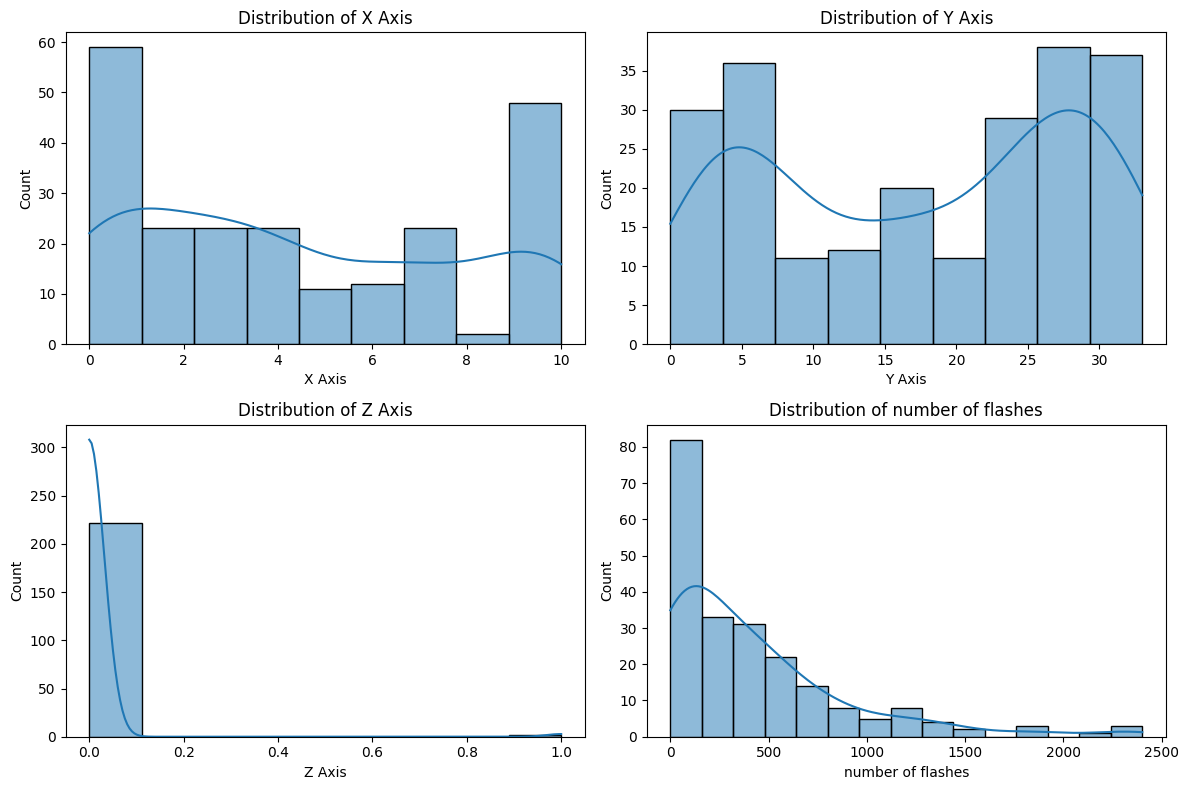

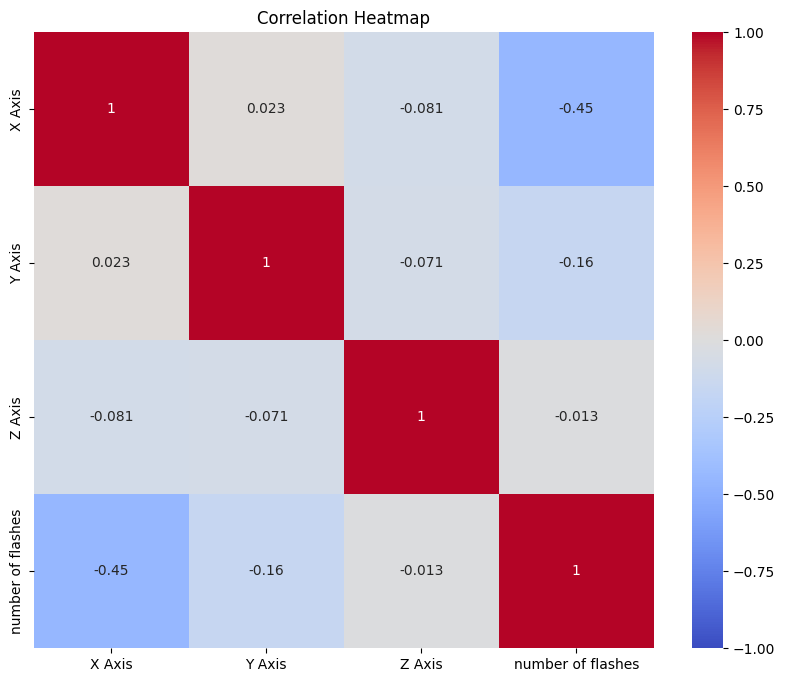

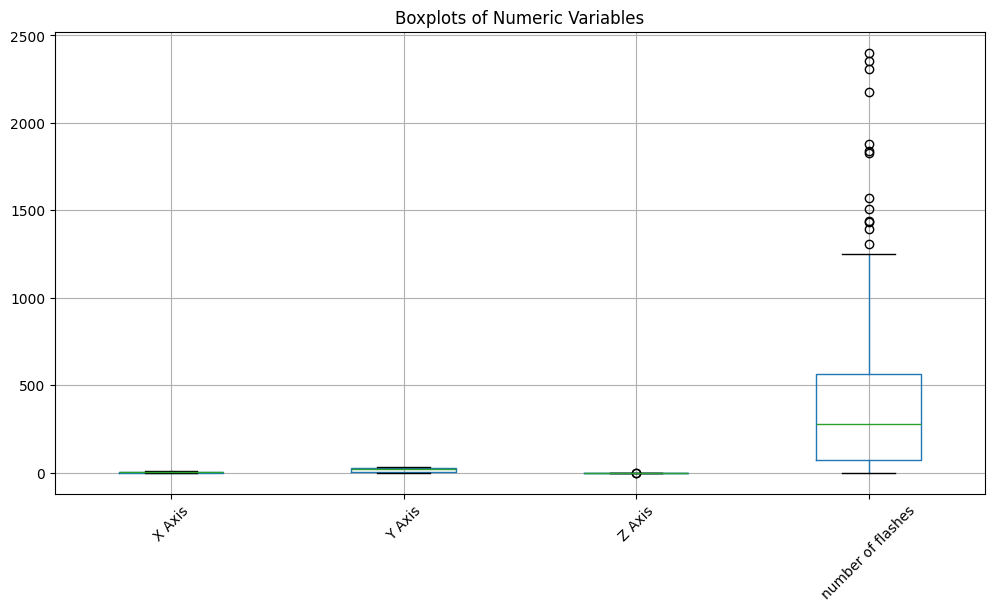

In [43]:
analyzer = DataAnalyzer(data)

# Get summary statistics
summary_stats = analyzer.get_summary_statistics()
display(summary_stats)
# Analyze distributions
distribution_analysis = analyzer.analyze_distributions()

# Create visualizations
analyzer.plot_distributions()
analyzer.plot_correlation_heatmap()
analyzer.plot_boxplots()

# Generate full report
report = analyzer.generate_report()

# 4. Générer des données 

## 4.1 TVAE

In [67]:
class TabularDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data,dtype=torch.float32)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

class TVAE(nn.Module):
    def __init__(self, input_dim, hidden_dims : list, latent_dim=32,use_batch_norm=True, dropout_rate = 0.2 , device = 'cpu'):
        super(TVAE, self).__init__()
        self.latent_dim = latent_dim
        self.input_dim = input_dim
        self.dropout_rate = dropout_rate
        self.device = device
        # Encoder
        pre_dim = self.input_dim
        encoder_layers = []
        for dim in hidden_dims:
            encoder_layers.append(nn.Linear(pre_dim, dim))
            if use_batch_norm == True:
                encoder_layers.append(nn.BatchNorm1d(dim))
            encoder_layers.extend([nn.LeakyReLU(0.2),
                                   nn.Dropout(dropout_rate),
                                  ])
            pre_dim = dim
        self.encoder = nn.Sequential(*encoder_layers)
       
        self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1], latent_dim)
        
        # Decoder
        pre_dim = latent_dim
        decoder_layers = []
        for dim in reversed(hidden_dims):
            decoder_layers.append(nn.Linear(pre_dim, dim))
            if use_batch_norm == True:
                decoder_layers.append(nn.BatchNorm1d(dim))
            decoder_layers.extend([nn.LeakyReLU(0.2),
                                   nn.Dropout(dropout_rate),
                                  ])
            pre_dim = dim
        decoder_layers.extend([
            nn.Linear(hidden_dims[0], input_dim),
            nn.Tanh() 
        ])
        
        self.decoder = nn.Sequential(*decoder_layers)
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.fill_(0.01)
    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_var(h)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std, device = self.device)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var
        
    def generate(self, n_samples):
        """Generate synthetic samples from random latent vectors"""
        with torch.no_grad():
            z = torch.randn(n_samples, self.latent_dim, device=self.device)
            return self.decode(z)
            
    def get_reconstruction_loss(self, x_recon, x, mu, log_var, beta=1.0):
        """
        Compute VAE loss with adjustable β-VAE formulation
        """
        # Reconstruction loss (MSE)
        recon_loss = F.mse_loss(x_recon, x, reduction='sum')
        #print(recon_loss.device)
        
        # KL divergence loss
        kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        # Total loss with β weighting
        total_loss = recon_loss + beta * kl_loss
        
        return {
            'total_loss': total_loss,
            'reconstruction_loss': recon_loss,
            'kl_loss': kl_loss
        }
    
    def interpolate(self, x1, x2, steps=10):
        """Interpolate between two input samples in latent space"""
        with torch.no_grad():
            # Encode both inputs
            mu1, _ = self.encode(x1.unsqueeze(0))
            mu2, _ = self.encode(x2.unsqueeze(0))
            
            # Create interpolation points
            alphas = torch.linspace(0, 1, steps)
            interpolated = []
            
            # Generate intermediate points
            for alpha in alphas:
                z = mu1 * (1 - alpha) + mu2 * alpha
                interpolated.append(self.decode(z))
                
            return torch.cat(interpolated, dim=0)
            
    def compute_metrics(self, x, x_recon):
        """Compute quality metrics for generated samples"""
        with torch.no_grad():
            # Mean absolute error
            mae = F.l1_loss(x_recon, x, reduction='mean')
            
            # Mean squared error
            mse = F.mse_loss(x_recon, x, reduction='mean')
            
            # Cosine similarity
            cos_sim = F.cosine_similarity(x_recon, x).mean()
            
            return {
                'mae': mae.item(),
                'mse': mse.item(),
                'cosine_similarity': cos_sim.item()
            }

def train_tvae(model, train_loader, val_loader, num_epochs=100, learning_rate=1e-2):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
    #scheduler = MultiStepLR(optimizer, milestones=[50,80], gamma=0.1)
    start_time = time.time()
    epoch_times = []
    
    print(f"Training started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    for epoch in range(num_epochs):
        epoch_start = time.time()
        total_loss = 0
        model.train()
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            
            # Forward pass
            recon_batch, mu, log_var = model(batch)
            #print(model.device)
            # loss
            loss = model.get_reconstruction_loss(recon_batch,batch, mu, log_var )['total_loss']
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
        val_loss = compute_validation_loss(model, val_loader, device)
        scheduler.step(val_loss)
        
        if (epoch + 1) % 10 == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(f'Epoch [{epoch+1}/{num_epochs}], Train loss: {total_loss/len(train_loader.dataset):.4f}, Val loss: {val_loss}, Learning Rate = {current_lr:.4f}')
            epoch_end = time.time()
            epoch_duration = epoch_end - epoch_start
            epoch_times.append(epoch_duration)
    print(f"Training finished at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    total_duration = time.time() - start_time
    print(f"Total training time: {format_time(total_duration)}")
def generate_synthetic_data(model, n_samples, original_data):
    model.eval()
    with torch.no_grad():
        # Sample from latent space
        z = torch.randn(n_samples, model.fc_mu.out_features)
        # Generate synthetic data
        synthetic_data = model.decode(z)
    return synthetic_data.numpy()

def compute_validation_loss(model, val_loader, device):
    model.eval()  # Set model to evaluation mode
    total_loss = 0.0

    with torch.no_grad():  # Disable gradient computation
        for batch in val_loader:
            batch = batch.to(device)  # Move data to GPU/CPU
            recon_batch, mu, log_var = model(batch)  # Forward pass
            loss_dict = model.get_reconstruction_loss(
                recon_batch, batch, mu, log_var
            )
            total_loss += loss_dict['total_loss'].item()  # Sum losses

    # Average loss over the entire validation set
    avg_loss = total_loss / len(val_loader.dataset)
    return avg_loss

## Test

In [26]:
device = torch.device('cuda')
n_samples = 100

In [69]:
def format_time(seconds):
    """Convert seconds to a human-readable format"""
    return str(timedelta(seconds=int(seconds)))
def main():
    # Create sample data
    original_data = num
    n_features =  num.shape[1]
    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(original_data)
    
    # Create dataset and dataloader
    dataset = TabularDataset(scaled_data)
    
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    
    
    
    # Initialize and train TVAE
    model = TVAE(input_dim=n_features,latent_dim = 8,hidden_dims=[64,64,32,32,16,16], device = device) 
    model = model.to(device)

    train_tvae(model, train_loader, val_loader,num_epochs=200, learning_rate=0.1)
    model = model.to('cpu')
    # Generate synthetic data
    synthetic_data = generate_synthetic_data(model, n_samples, original_data)
    
    # Inverse transform the synthetic data
    synthetic_data_original_scale = scaler.inverse_transform(synthetic_data)
    
    # Convert to DataFrame
    synthetic_df = pd.DataFrame(
        synthetic_data_original_scale,
        columns=[f'feature_{i+1}' for i in range(n_features)]
    )
    
    return synthetic_df

if __name__ == "__main__":
    synthetic_df = main()
    print("\nSynthetic Data Sample:")
    print(synthetic_df.head())
    print("\nSynthetic Data Statistics:")
    print(synthetic_df.describe())

Training started at: 2025-02-11 16:42:00
Epoch [10/200], Train loss: 4.8606, Val loss: 3.126905822753906, Learning Rate = 0.1000
Epoch [20/200], Train loss: 4.4327, Val loss: 2.909297137790256, Learning Rate = 0.1000
Epoch [30/200], Train loss: 4.3980, Val loss: 3.0285129970974394, Learning Rate = 0.0250
Epoch [40/200], Train loss: 4.3247, Val loss: 2.994123331705729, Learning Rate = 0.0125
Epoch [50/200], Train loss: 4.2853, Val loss: 2.957501008775499, Learning Rate = 0.0031
Epoch [60/200], Train loss: 4.3255, Val loss: 2.975092993842231, Learning Rate = 0.0008
Epoch [70/200], Train loss: 4.3154, Val loss: 2.9637666914198135, Learning Rate = 0.0004
Epoch [80/200], Train loss: 4.2760, Val loss: 2.9700767517089846, Learning Rate = 0.0001
Epoch [90/200], Train loss: 4.2710, Val loss: 2.964396752251519, Learning Rate = 0.0000
Epoch [100/200], Train loss: 4.3029, Val loss: 2.968418248494466, Learning Rate = 0.0000
Epoch [110/200], Train loss: 4.2934, Val loss: 2.961078135172526, Learning 

In [131]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
model = TVAE(input_dim=10,hidden_dims=[512,256,256,128,128,64,64], device = device) 
count_parameters(model)

541002

In [44]:
a = pd.DataFrame({'a': [1,2], 'b':[3,4]})

In [48]:
a['b'] = [4,5]
a

,a,b
0,1,4
1,2,5


In [72]:
num.isnull().sum()

X Axis               0
Y Axis               0
Z Axis               0
number of flashes    0
dtype: int64